# Chart Pattern Recognition

This feature engineering example involves a method for chart pattern recognition. Stemming from the idea that voice recognition is basically looking for patterns in waveforms, it seemed plausible that this could apply to normalized stock returns. This example uses closing price data for Microsoft from January 2000 to April 2018 (data from Quandl).

The following approach takes a rolling one-month window of price data, normalizes the data by converting it to cumulative percent returns over the period, and then stores the pattern. Next, it steps the window forward by one day and repeats the process to collect all possible historical patterns.

Then we can compare the current period’s pattern to historical patterns, extract those patterns similar to the current pattern, and use the mean outcome of those similar patterns as the basis for the buy or sell recommendation. This is shown by the dots on the right-hand side of the chart — the green and red dots are the outcomes of the historical patterns, the yellow dot is the mean of those outcomes, which is the recommendation, and the purple dot is the actual outcome of the current pattern being evaluated.

![alt text](chart.png "Title")

Testing this across about 200 patterns to evaluate predictive strength generated a 64% accuracy rate which is encouraging.

![alt text](table.png "Title")

### Import dependencies

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import style
style.use("ggplot")
%matplotlib inline

### Import data

In [5]:
stock = pd.read_csv('msft_prices.csv', parse_dates=[0]).set_index('Date') # parse dates convert from str to date, [0] is col index
price = stock.Close.values # convert closing prices to numpy array

### Set up the rolling window function

In [8]:
def strided_app(prices, window_len, stride_step=1):
    ''' Takes a winow length of data points, steps forward by the stride_step, and
        repeats to collect all the data points into an array. 
        
        Parameters
        ----------
        prices = closing price data
        window_len = 21 for 20 trading days or a 1 month window 
        stride_step = step the window forward by one day 
        
        Output
        ------
        Strided window of determined length and step function '''    
    
    nrows = ((prices.size - window_len)//stride_step) + 1
    n = prices.strides[0]
    
    return np.lib.stride_tricks.as_strided(prices, shape=(nrows, window_len), 
                                           strides=(stride_step * n, n))

### Collect historical patterns of cumulative percentage price return data

In [22]:
def stored_cumPatterns(prices, window_len, stride_step=1):
    ''' Collects cumulative pct-change patterns (which normalizes the data) over 
        the window period for each step forward (stride) through the price series. '''   

    # Array where each row has window_len of closing prices, by calling the strided_app function
    pattern_window = strided_app(prices, window_len, stride_step)
    # Normalize closing prices to cumulative percentage returns
    stored_cum_patts = (pattern_window[:,1:] / pattern_window[:,0:1] - 1) * 100
    
    return stored_cum_patts

The first two rows of window percentage returns are shown below, each row with 20 days of cumulative return figures.

In [27]:
stored_cumPatterns(prices=price, window_len=21, stride_step=1)[:2]

array([[ -3.38023336,  -2.35929993,  -5.62800275,  -4.39258751,
         -3.69766644,  -6.16849691,  -9.22271791,  -7.50686342,
         -3.69766644,  -1.07240906,  -8.20178449,  -9.05971174,
        -10.99004804, -13.13486616, -11.79649966, -14.74776939,
        -15.27968428, -15.70864791, -16.03466026, -11.68496911],
       [  1.05665068,  -2.32640739,  -1.04777127,  -0.32853845,
         -2.88581069,  -6.04688332,  -4.27099982,  -0.32853845,
          2.38856331,  -4.99023264,  -5.87817439,  -7.87604333,
        -10.09589771,  -8.71070858, -11.7652282 , -12.31575209,
        -12.75972296, -13.09714083,  -8.59527615, -10.48659208]])

In [28]:
def stored_dailyPatterns(prices, window_len, stride_step=1):
    ''' Gets the daily percent change patterns for the period. '''   
    
    # Array where each row has window_len of closing prices, by calling the strided_app function
    pattern_window = strided_app(prices, window_len, stride_step)
    # Normalize closing prices to daily percentage returns
    stored_daily_patts = (pattern_window[:,1:] / pattern_window[:,:-1] - 1) * 100

    return stored_daily_patts

### Collect the current pattern of cumulative percentage price return for comparison

In [18]:
def curr_cumPattern(prices, curr_patt_start, window_len, stride_step=1):
    ''' Gets the specified cumulative pct-change pattern for the window period. '''
    
    stored_cum_patts = stored_cumPatterns(prices, window_len, stride_step)
    curr_cum_patt = stored_cum_patts[curr_patt_start].reshape(1,-1)
    
    return curr_cum_patt

A current 20-day pattern is shown below, taken from the 500th trading day within the price history as a starting point for the window period.

In [29]:
curr_cumPattern(prices=price, curr_patt_start=500, window_len=21, stride_step=1)

array([[ 3.26670644,  2.77446301,  2.2673031 ,  3.49045346,  2.49105012,
         3.34128878,  2.34188544,  2.13305489,  3.74403341,  1.23806683,
         4.20644391, -1.40214797, -3.84844869, -4.92243437, -3.63961814,
        -4.83293556, -4.80310263, -7.04057279, -6.25      , -4.96718377]])

In [19]:
def curr_dailyPattern(prices, curr_patt_start, window_len, stride_step=1):
    ''' Gets the daily percent change patterns for the period. '''  
    
    stored_daily_patts = stored_dailyPatterns(prices, window_len, stride_step)
    curr_daily_patt = stored_daily_patts[curr_patt_start].reshape(1,-1)
    
    return curr_daily_patt

### Compare current pattern to historical patterns for recognition

A simple way to identify similar patterns is to compare the number of up/down days in the window period. This can be done by converting the pct-change patterns to positive/negative days using numpy.sign. Then count those days in the window period where the sign matches the stored pattern and divide by the number of elements in the window period to get a percentage of days matched. Once all stored patterns have been compared to the current pattern, a cut-off threshold for a minimum level of similarity can then be applied to extract only those deemed similar enough. Conceptually, this is akin to a right-tail significance interval of a distribution.

This isn't ideal as matching daily returns can understate the match while cumulative returns can overstate the match. To overcome this, an average of the daily and cumulative comparisons has been used as a compromise.

In [20]:
def pattComp(prices, curr_patt_start, window_len, stride_step=1):
    ''' Counts the number of same-sign returns where a cut-off threshold for 
        similarity can be applied. This needs to be an average of cumulative
        daily comparisons for a more stable cut-off threshold level. '''     
    
    # Call the current cumulative return pattern and stored cumulative return patterns:
    curr_cum_patt = curr_cumPattern(prices, curr_patt_start, window_len, 
                                    stride_step).reshape(1,-1)
    stored_cum_patts = stored_cumPatterns(prices, window_len, stride_step)
    
    
    # Call the current daily return pattern and stored daily return patterns:
    curr_daily_patt = curr_dailyPattern(prices, curr_patt_start, window_len, 
                                        stride_step).reshape(1,-1)
    stored_daily_patts = stored_dailyPatterns(prices, window_len, stride_step)
    
    # Count the number of matching signs, divide by window elements to get matching percent
    cum_comp = np.sum( np.sign(curr_cum_patt) == 
               np.sign(stored_cum_patts), axis=1 ) / curr_cum_patt.size    
    daily_comp = np.sum( np.sign(curr_daily_patt) == 
               np.sign(stored_daily_patts), axis=1 ) / curr_daily_patt.size
    
    # Take the blended average of the two comparison methods above
    both_comp = np.mean((daily_comp, cum_comp), axis=0)
    
    return cum_comp, daily_comp, both_comp

#### Plot a historgram of pattern similarities to get a sense of what is going on...

Overlaying the distribution of pattern comparisons for the cumulative returns, daily returns and the average of the two gives a clearer picture or sense of what things look like. Change the curr_patt_start to anything less than 4565 (which is the index start point for the most recent pattern for comparison) to see how the distributions vary. 

In [30]:
def plotHistograms(prices, curr_patt_start, window_len, stride_step=1):
    
    cum_comp, daily_comp, both_comp = pattComp(prices, curr_patt_start, 
                                               window_len, stride_step)

    plt.hist(both_comp, label='both_comp', alpha=0.7)
    names = ['cum_comp', 'daily_comp']
    plt.hist([cum_comp, daily_comp], label=names , alpha=0.8)
    
    plt.title('Both Pattern Comparison')
    plt.legend()

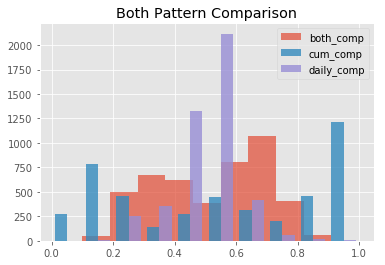

In [46]:
plotHistograms(prices=price, curr_patt_start=4560, window_len=21, stride_step=1)

### Retrieve the similar patterns

With the current pattern compared to all previous patterns, we can now extract only the similar ones by defining a minimum cut-off threshold for perecentage similarity.

In [49]:
def retrieve_cumSimPatts(prices, curr_patt_start, window_len, sim_threshold, 
                         stride_step=1):
    ''' need to retrieve stored_cumPatts that correspond w the stored_dailyPatts.
        -- use patt_sim_index to lookup from stored_cumPatts '''
    
    patt_similarity = pattComp(prices, curr_patt_start, window_len, stride_step)[2] # 2=both_comp
    patt_sim_index = np.where(patt_similarity > sim_threshold)[0]
    sim_patts_cum = stored_cumPatterns(prices, window_len, stride_step)[patt_sim_index]
    
    return sim_patts_cum

As an example, below shows the current pattern (from index start 4560) has 60 historical patterns that match with an 80% degree of similarity.

In [55]:
retrieve_cumSimPatts(prices=price, curr_patt_start=4560, window_len=21, 
                     sim_threshold=0.8, stride_step=1).shape[0]

60

In [48]:
def retrieve_dailySimPatts(prices, curr_patt_start, window_len, sim_threshold, 
                           stride_step=1):
    
    patt_similarity = pattComp(prices, curr_patt_start, window_len, stride_step)[2] # 2=both_comp
    patt_sim_index = np.where(patt_similarity > sim_threshold)[0]
    sim_patts_daily = stored_dailyPatterns(prices, window_len, stride_step)[patt_sim_index]
    
    return sim_patts_daily

### Evaluate the pattern outcomes

These functions calculate the returns of the patterns that are similar to the current pattern and then uses the mean of those similar returns as the predicted return for current pattern we are trying to predict.

In [68]:
def stored_patts_returnOutcome(prices, curr_patt_start, window_len, return_period, 
                               sim_threshold, stride_step=1):
    ''' Then need to get the start price of the corresponding matched pattern from 
        stored_cumPatts to calculate the return. (use the start price because we
        are extending the cumulative return pattern. '''
    patt_similarity = pattComp(prices, curr_patt_start, window_len, stride_step)[2] # 2=both_comp
    
    startprice_index = np.where(patt_similarity > sim_threshold)[0]
    stored_patts_startprice = prices[startprice_index]
    
    outcome_prices_index = np.clip(np.where(patt_similarity > sim_threshold)[0] +
                                    return_period+window_len, a_min=0, 
                                    a_max=len(prices)-window_len)
    stored_patts_outcome_prices = prices[outcome_prices_index]
    
    stored_patts_outcome_returns = (stored_patts_outcome_prices / 
                                    stored_patts_startprice -1 ) * 100
    
    return stored_patts_outcome_returns

In [69]:
def predictedOutcome(prices, curr_patt_start, window_len, return_period, 
                     sim_threshold, stride_step=1):
    ''' Predicted outcome is just be the average of past similar patt outcomes. '''
    
    stored_patts_outcome_returns = stored_patts_returnOutcome(prices, curr_patt_start, 
                                                             window_len, return_period, 
                                                             sim_threshold, stride_step)
    
    return np.mean(stored_patts_outcome_returns)

This function calculates the actual return of the pattern we are trying to predict.

In [70]:
def curr_patt_returnOutcome(prices, curr_patt_start, window_len, return_period):  # curr_patt_start will be 'i' in the loop
    ''' Actual cumulative return of the current pattern. '''  
    curr_patt_start_price = prices[curr_patt_start]
    curr_patt_outcome_price = prices[curr_patt_start + window_len + return_period-1]
    curr_patt_outcome_return = (curr_patt_outcome_price / curr_patt_start_price -1 ) * 100
    
    return curr_patt_outcome_return

### Visualizations

In [74]:
def run_charts(prices, curr_patt_start, window_len, return_period, 
               sim_threshold, stride_step=1):
    
    fig = plt.figure(figsize=(9,9)) 
    
    curr_cum_patt = curr_cumPattern(prices, curr_patt_start, window_len, stride_step)
    curr_daily_patt = curr_dailyPattern(prices, curr_patt_start, window_len, stride_step)
    sim_patts_cum = retrieve_cumSimPatts(prices, curr_patt_start, window_len, 
                                         sim_threshold, stride_step)
    sim_patts_daily = retrieve_dailySimPatts(prices, curr_patt_start, window_len, 
                                             sim_threshold, stride_step)
    
    stored_patts_outcome_returns = stored_patts_returnOutcome(prices, curr_patt_start, 
                                                             window_len, return_period, 
                                                             sim_threshold, stride_step)
    
    pred_outcome = predictedOutcome(prices, curr_patt_start, window_len, return_period, 
                                    sim_threshold, stride_step)    
    
    curr_patt_outcome_return = curr_patt_returnOutcome(prices, curr_patt_start, 
                                                       window_len, return_period)    
    

    # CUMULATIVE PATTERNS
    ax1 = fig.add_subplot(211)
    # Similar patterns:
    counter = 0
    for i in sim_patts_cum:       
        if stored_patts_outcome_returns[counter:counter+1] > curr_cum_patt[0][-1]:
            dot_color = 'green'
        else: dot_color = 'red'        
        plt.scatter( window_len + return_period - 1, 
                    stored_patts_outcome_returns[counter:counter+1], 
                    c = dot_color, alpha=0.3)        
        plt.plot(sim_patts_cum[counter:counter+1][0], alpha=0.5)
        counter += 1
    # Predicted Outcome:
    plt.scatter( window_len + return_period - 2 , pred_outcome, 
                c='yellow', label = 'Predicted Outcome') 
    # Actual Outcome:
    plt.scatter( window_len + return_period - 2 , curr_patt_outcome_return , 
                c='purple', label = 'Actual Outcome')
    # Current Pattern:
    plt.plot(curr_cum_patt[0], linewidth=3, c='blue', label = 'Current Pattern')    
    plt.title('Cumulative Pattern Comparison')
    plt.legend()


    # DAILY PATTERNS
    ax2 = fig.add_subplot(212)
    plt.scatter(window_len + return_period - 1, 1, c='grey', alpha=0.01) # this is just to keep x-axis same as cumulative chart
    # Similar patterns:
    counter = 0
    for i in sim_patts_daily:
        plt.plot(sim_patts_daily[counter:counter+1][0], alpha=0.5)
        counter += 1
    # Current Pattern:
    plt.plot(curr_daily_patt[0], linewidth=3, c='blue', label = 'Current Pattern')
    plt.title('Daily Pattern Comparison')
    plt.legend()

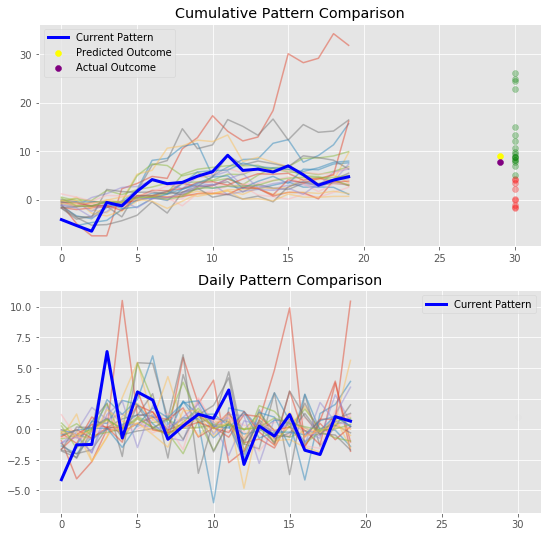

In [111]:
run_charts(prices=price, curr_patt_start=455, window_len=21, return_period=10, 
           sim_threshold=0.8)

In [80]:
def run_update(prices, window_len, return_period, sim_threshold, stride_step=1):  
    
    # Setup empty df to capture scores:
    confusion_matrix = pd.DataFrame(columns = ['Up_pred', 'Down_pred'])
    confusion_matrix['Scores'] = ['Up_outcome', 'Down_outcome', 'Accuracy']
    confusion_matrix = confusion_matrix.set_index('Scores')
    
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    
    
    for i in range(1, int(len(prices)/window_len)):
        curr_patt_start = len(prices) - return_period - window_len*i
        
        # Storing patterns:
        stored_cum_patts =  stored_cumPatterns(prices, window_len, stride_step=1)
        stored_daily_patts = stored_dailyPatterns(prices, window_len, stride_step=1)
        
        curr_cum_patt = curr_cumPattern(prices, curr_patt_start, window_len, stride_step)
        curr_daily_patt = curr_dailyPattern(prices, curr_patt_start, window_len, stride_step)   
        
        # Comparing patterns:
        patt_comps = pattComp(prices, curr_patt_start, window_len, stride_step)[2] # 2=both_comp
        sim_patts_daily = retrieve_dailySimPatts(prices, curr_patt_start, window_len, 
                                                 sim_threshold, stride_step)
        sim_patts_cum = retrieve_cumSimPatts(prices, curr_patt_start, window_len, 
                                             sim_threshold, stride_step)
        # Pattern return outcomes and pred:
        stored_patts_outcome_returns = stored_patts_returnOutcome(prices, curr_patt_start, 
                                                                  window_len, 
                                                                  return_period, 
                                                                  sim_threshold, 
                                                                 stride_step)
        pred_outcome =      predictedOutcome(prices, curr_patt_start, window_len, 
                                             return_period, sim_threshold, stride_step)
        curr_patt_outcome_return = curr_patt_returnOutcome(prices, curr_patt_start, 
                                                           window_len, return_period)
        
        # Scoring:        
        if pred_outcome > curr_cum_patt[0][-1] and curr_patt_outcome_return >= curr_cum_patt[0][-1]:
            true_positive += 1
        elif pred_outcome > curr_cum_patt[0][-1] and curr_patt_outcome_return < curr_cum_patt[0][-1]:
            false_positive += 1
        elif pred_outcome < curr_cum_patt[0][-1] and curr_patt_outcome_return <=  curr_cum_patt[0][-1]:
            true_negative += 1
        else: false_negative += 1
                

    # Record scores in rgr_scores df:
    confusion_matrix.iloc[0, 0] = true_positive
    confusion_matrix.iloc[0, 1] = false_positive
    confusion_matrix.iloc[1, 1] = true_negative
    confusion_matrix.iloc[1, 0] = false_negative
    
    correct_preds = true_positive + true_negative
    incorrect_preds = false_positive + false_negative
    accuracy = correct_preds / (correct_preds + incorrect_preds)
    
    confusion_matrix.iloc[2:3, 0:1] = accuracy

    return confusion_matrix

In [81]:
run_update(prices=price, window_len=21, return_period=10, sim_threshold=0.8, stride_step=1)

,Up_pred,Down_pred
Scores,,
Up_outcome,89,39
Down_outcome,40,49
Accuracy,0.635945,NaN
